In [53]:
from tqdm import tqdm
import numpy as np
import tensorflow as tf
import tensorflow
import keras
import medmnist
from medmnist import INFO, Evaluator
import os
from tensorflow.keras.layers import Dense, Dropout, Flatten, Softmax, BatchNormalization
from tensorflow.keras.layers.experimental.preprocessing import Resizing
import medmnist.dataset as dt
from keras.applications import VGG16, ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt

In [54]:
gpus = tf.config.list_physical_devices()
tf.config.set_visible_devices(gpus[3], 'GPU')
gpus

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:4', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:5', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:6', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:7', device_type='GPU')]

In [55]:
data_train = dt.BloodMNIST("train", download=True)

Using downloaded and verified file: /data/home/karmpatel/.medmnist/bloodmnist.npz


In [56]:
data_test = dt.BloodMNIST("test", download=True)

Using downloaded and verified file: /data/home/karmpatel/.medmnist/bloodmnist.npz


In [57]:
X_train, X_test = data_train.imgs, data_test.imgs
print(X_train.shape, X_test.shape)

y_train, y_test = data_train.labels, data_test.labels
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print(y_train.shape, y_test.shape)

# preprocessing
X_train = X_train/255
X_test = X_test/255

(11959, 28, 28, 3) (3421, 28, 28, 3)
(11959, 8) (3421, 8)


In [58]:
X_train = tf.keras.applications.resnet50.preprocess_input(X_train)
X_test = tf.keras.applications.resnet50.preprocess_input(X_test)

In [59]:
train_datagen = ImageDataGenerator(
        featurewise_center=True, 
        featurewise_std_normalization=True, 
        )

test_datagen = ImageDataGenerator(
        featurewise_center=True, 
        featurewise_std_normalization=True, 
        )

train_datagen.fit(X_train)
test_datagen.fit(X_test)

In [60]:
data_train.info["label"]

{'0': 'basophil',
 '1': 'eosinophil',
 '2': 'erythroblast',
 '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)',
 '4': 'lymphocyte',
 '5': 'monocyte',
 '6': 'neutrophil',
 '7': 'platelet'}

In [61]:
n_classes = len(data_train.info["label"])

In [63]:
resnet50_model = ResNet50(weights="imagenet", input_shape=(32, 32, 3), include_top=False)
resnet50_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_11[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [68]:
def resnet_all_freeze(resnet50_model, layers = 0):
    
    #Freezing
    resnet50_model.trainable = True
    for i in range(len(resnet50_model.layers)-layers):
        resnet50_model.layers[i].trainable = False
    
    # add layers
    transfer_model = keras.Sequential()
    transfer_model.add(Resizing(32,32))
    transfer_model.add(resnet50_model)
    transfer_model.add(Flatten())
    transfer_model.add(Dense(1024, activation='relu', name='hidden1'))
    transfer_model.add(BatchNormalization())
    transfer_model.add(Dropout(0.5))
    transfer_model.add(Dense(512, activation='relu', name='hidden2'))
    transfer_model.add(BatchNormalization())
    transfer_model.add(Dropout(0.5))
    transfer_model.add(Dense(n_classes, activation='softmax', name='predictions'))
    
    # build
    transfer_model.build((None,None,None,3))
    
    # compile
    transfer_model.compile(
    optimizer=keras.optimizers.RMSprop(0.0005),
    loss=keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
    )
    
    return transfer_model

In [69]:
transfer_model_1 = resnet_all_freeze(resnet50_model)
transfer_model_1.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_8 (Resizing)        (None, 32, 32, 3)         0         
_________________________________________________________________
resnet50 (Functional)        (None, 1, 1, 2048)        23587712  
_________________________________________________________________
flatten_8 (Flatten)          (None, 2048)              0         
_________________________________________________________________
hidden1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
batch_normalization_16 (Batc (None, 1024)              4096      
_________________________________________________________________
dropout_16 (Dropout)         (None, 1024)              0         
_________________________________________________________________
hidden2 (Dense)              (None, 512)              

In [70]:
epochs = 20
history = transfer_model_1.fit(train_datagen.flow(X_train, y_train, batch_size=32), epochs=epochs, shuffle=True, 
                               validation_data=test_datagen.flow(X_test, y_test))

Epoch 1/20
374/374 [==============================] - 11s 17ms/step - loss: 1.5783 - accuracy: 0.5413 - val_loss: 4.2098 - val_accuracy: 0.2745
Epoch 2/20
374/374 [==============================] - 5s 13ms/step - loss: 1.1688 - accuracy: 0.6212 - val_loss: 3.8917 - val_accuracy: 0.3101
Epoch 3/20
374/374 [==============================] - 5s 13ms/step - loss: 1.0064 - accuracy: 0.6552 - val_loss: 5.2784 - val_accuracy: 0.2555
Epoch 4/20
374/374 [==============================] - 5s 14ms/step - loss: 0.9637 - accuracy: 0.6616 - val_loss: 4.5506 - val_accuracy: 0.2423
Epoch 5/20
374/374 [==============================] - 5s 13ms/step - loss: 0.8877 - accuracy: 0.6784 - val_loss: 5.9390 - val_accuracy: 0.2078
Epoch 6/20
374/374 [==============================] - 5s 12ms/step - loss: 0.8614 - accuracy: 0.6877 - val_loss: 5.8682 - val_accuracy: 0.1798
Epoch 7/20
374/374 [==============================] - 5s 13ms/step - loss: 0.8087 - accuracy: 0.7073 - val_loss: 5.5151 - val_accuracy: 0.166

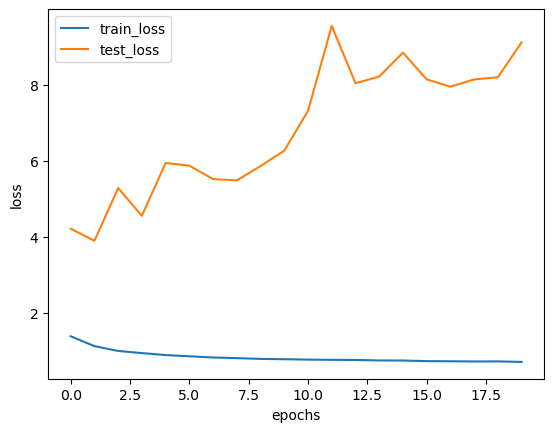

In [79]:
plt.plot(history.history["loss"], label = "train_loss")
plt.plot(history.history["val_loss"], label = "test_loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()

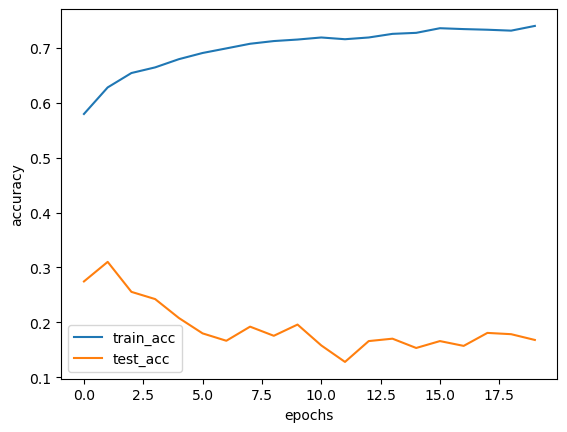

In [80]:
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="test_acc")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.legend()

## Unfreeze all layers

In [73]:
transfer_model_2 = resnet_all_freeze(resnet50_model, layers=len(resnet50_model.layers))
transfer_model_2.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_9 (Resizing)        (None, 32, 32, 3)         0         
_________________________________________________________________
resnet50 (Functional)        (None, 1, 1, 2048)        23587712  
_________________________________________________________________
flatten_9 (Flatten)          (None, 2048)              0         
_________________________________________________________________
hidden1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
batch_normalization_18 (Batc (None, 1024)              4096      
_________________________________________________________________
dropout_18 (Dropout)         (None, 1024)              0         
_________________________________________________________________
hidden2 (Dense)              (None, 512)              

In [74]:
epochs = 15
results_2 = transfer_model_2.fit(train_datagen.flow(X_train, y_train, batch_size=32), epochs=epochs, shuffle=True, 
                               validation_data=test_datagen.flow(X_test, y_test))

Epoch 1/15
374/374 [==============================] - 27s 41ms/step - loss: 1.8178 - accuracy: 0.4778 - val_loss: 20870.4863 - val_accuracy: 0.1692
Epoch 2/15
374/374 [==============================] - 15s 39ms/step - loss: 0.9683 - accuracy: 0.6897 - val_loss: 1101.1085 - val_accuracy: 0.1824
Epoch 3/15
374/374 [==============================] - 14s 38ms/step - loss: 0.6431 - accuracy: 0.7916 - val_loss: 1144.1843 - val_accuracy: 0.1824
Epoch 4/15
374/374 [==============================] - 15s 40ms/step - loss: 0.5053 - accuracy: 0.8372 - val_loss: 2784.4221 - val_accuracy: 0.1824
Epoch 5/15
374/374 [==============================] - 14s 38ms/step - loss: 0.4394 - accuracy: 0.8597 - val_loss: 4079.3838 - val_accuracy: 0.1824
Epoch 6/15
374/374 [==============================] - 14s 38ms/step - loss: 0.3604 - accuracy: 0.8838 - val_loss: 1443.7430 - val_accuracy: 0.1824
Epoch 7/15
374/374 [==============================] - 14s 38ms/step - loss: 0.3337 - accuracy: 0.8903 - val_loss: 666

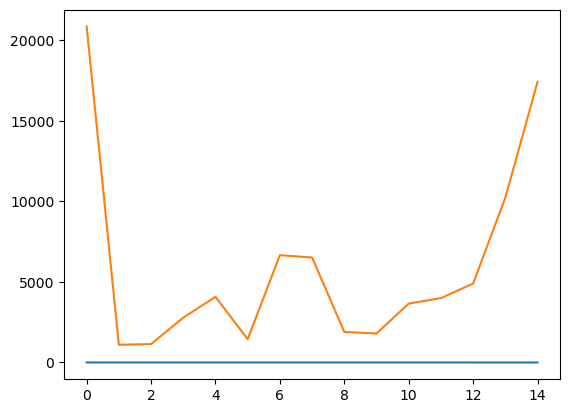

In [76]:
plt.plot(results_2.history["loss"])
plt.plot(results_2.history["val_loss"])

In [35]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

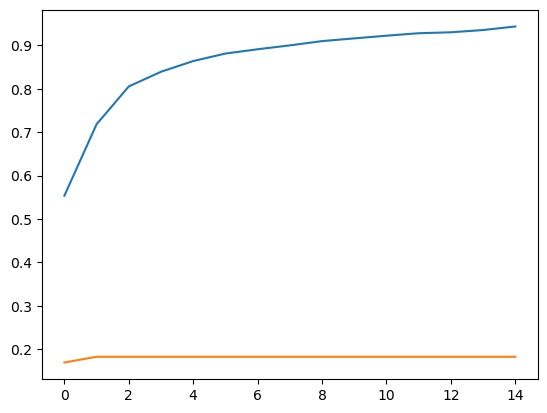

In [77]:
plt.plot(results_2.history["accuracy"])
plt.plot(results_2.history["val_accuracy"])